## 난임 환자 대상 임신 성공 여부 예측

### LGAimers 6th 온라인 해커톤

### Import

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

In [40]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # 평가
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    cm = confusion_matrix(y_test, y_pred)
    
    # 결과 출력
    print()
    print("--- Model Performance ---")
    print(f"Model Accuracy: {accuracy}")
    print(f"Model F1 Score: {f1}")
    print(f"Model AUC: {auc}")
    
    # 혼동 행렬 출력
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    
    return y_pred, y_pred_proba

### Data Load

In [41]:
# 데이터 로드
IVF_train = pd.read_csv('../data/IVF_train_dataset_54.csv')
IVF_test = pd.read_csv('../data/IVF_test_dataset_54.csv')

DI_train = pd.read_csv('../data/DI_train_dataset_54.csv')
DI_test = pd.read_csv('../data/DI_test_dataset_54.csv')

In [42]:
# ID 열을 제외한 특성과 타겟 변수 분리
IVF_X = IVF_train.drop(['임신_성공_여부', 'ID'], axis=1)
IVF_y = IVF_train['임신_성공_여부']

DI_X = DI_train.drop(['임신_성공_여부', 'ID'], axis=1)
DI_y = DI_train['임신_성공_여부']

In [43]:
print(f"IVF_X shape: {IVF_X.shape}")
print(f"IVF_test shape: {IVF_test.drop('ID', axis=1).shape}")

print(f"DI_X shape: {DI_X.shape}")
print(f"DI_test shape: {DI_test.drop('ID', axis=1).shape}")

IVF_X shape: (250052, 77)
IVF_test shape: (87891, 77)
DI_X shape: (6289, 31)
DI_test shape: (2176, 31)


### 인코딩 

In [44]:
IVF_categorical_columns = [
    "시술_시기_코드",
    "시술_당시_나이",
    "특정_시술_유형",
    "배란_유도_유형",
    "난자_출처",
    "정자_출처",
    "난자_기증자_나이",
    "정자_기증자_나이",
    "채취_해동_차이",
    "해동_혼합_차이",
    "혼합_이식_차이",
    "이식_해동_차이"
]

In [45]:
DI_categorical_columns = [
    "시술_시기_코드",
    "시술_당시_나이",
    "특정_시술_유형",
    "정자_기증자_나이"
]

In [46]:
# 모든 범주형 변수를 문자열로 변환
IVF_X[IVF_categorical_columns] = IVF_X[IVF_categorical_columns].astype(str)
DI_X[DI_categorical_columns] = DI_X[DI_categorical_columns].astype(str)
IVF_test[IVF_categorical_columns] = IVF_test[IVF_categorical_columns].astype(str)
DI_test[DI_categorical_columns] = DI_test[DI_categorical_columns].astype(str)

# OrdinalEncoder를 사용하여 범주형 변수 인코딩
IVF_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
DI_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

IVF_X[IVF_categorical_columns] = IVF_encoder.fit_transform(IVF_X[IVF_categorical_columns])
DI_X[DI_categorical_columns] = DI_encoder.fit_transform(DI_X[DI_categorical_columns])
IVF_test[IVF_categorical_columns] = IVF_encoder.transform(IVF_test[IVF_categorical_columns])
DI_test[DI_categorical_columns] = DI_encoder.transform(DI_test[DI_categorical_columns])

## Modeling

In [47]:
# 데이터 분할
IVF_X_train, IVF_X_test, IVF_y_train, IVF_y_test = train_test_split(IVF_X, IVF_y, test_size=0.2, random_state=42)
DI_X_train, DI_X_test, DI_y_train, DI_y_test = train_test_split(DI_X, DI_y, test_size=0.2, random_state=42)

### IVF 데이터

In [54]:
import lightgbm as lgb
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# 데이터 분할 함수
def split_data(X, y, test_size=0.2, random_state=42):
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

# 여러 LightGBM 모델 학습 및 앙상블 구성
def train_and_ensemble(X, y, num_models=5, test_size=0.2, model_params=None):
    models = []
    for i in range(num_models):
        # 데이터 분할
        X_train, X_test, y_train, y_test = split_data(X, y, test_size=test_size, random_state=42 + i)
        
        # 모델 초기화
        model = lgb.LGBMClassifier(
            **model_params,
            random_state=42 + i  # 각 모델에 다른 시드 값 사용
        )
        
        # 모델 학습
        model.fit(X_train, y_train)
        models.append(model)
    
    return models, X_test, y_test

# 앙상블 예측 함수
def ensemble_predict(models, X):
    preds = np.zeros((X.shape[0], len(models)))
    for i, model in enumerate(models):
        preds[:, i] = model.predict_proba(X)[:, 1]
    return np.mean(preds, axis=1)

# 데이터 분할
IVF_X_train, IVF_X_test, IVF_y_train, IVF_y_test = train_test_split(IVF_X, IVF_y, test_size=0.2, random_state=42)
DI_X_train, DI_X_test, DI_y_train, DI_y_test = train_test_split(DI_X, DI_y, test_size=0.2, random_state=42)

# IVF 데이터에 대해 여러 LightGBM 모델 학습 및 앙상블 구성
IVF_model_params = {
    'n_estimators': 4471,
    'num_leaves': 13,
    'max_depth': 279,
    'learning_rate': 0.007075124517450591,
    'min_child_samples': 26,
    'subsample': 0.29772991936701476,
    'colsample_bytree': 0.8913054521763838,
    'reg_alpha': 0.0004860363321690653,
    'reg_lambda': 311.08056657247363,
    'min_split_gain': 0.18214905183450955,
    'boosting_type': 'gbdt',
    'verbose': -1
}
IVF_models, IVF_X_test, IVF_y_test = train_and_ensemble(IVF_X, IVF_y, num_models=5, test_size=0.2, model_params=IVF_model_params)

# 앙상블 예측
IVF_y_pred_proba = ensemble_predict(IVF_models, IVF_X_test)
IVF_y_pred = (IVF_y_pred_proba > 0.5).astype(int)

# 평가
auc = roc_auc_score(IVF_y_test, IVF_y_pred_proba)
print(f"IVF AUC: {auc}")

# DI 데이터에 대해 여러 LightGBM 모델 학습 및 앙상블 구성
DI_model_params = {
    'n_estimators': 1816,
    'num_leaves': 3926,
    'max_depth': 259,
    'learning_rate': 0.00238377640011148,
    'min_child_samples': 1,
    'subsample': 0.7610056627240331,
    'colsample_bytree': 0.6655579164853634,
    'reg_alpha': 0.00025227758337188327,
    'reg_lambda': 76.744107215122684,
    'min_split_gain': 0.007773520329665474,
    'boosting_type': 'gbdt',
    'verbose': -1
}
DI_models, DI_X_test, DI_y_test = train_and_ensemble(DI_X, DI_y, num_models=5, test_size=0.2, model_params=DI_model_params)

# 앙상블 예측
DI_y_pred_proba = ensemble_predict(DI_models, DI_X_test)
DI_y_pred = (DI_y_pred_proba > 0.5).astype(int)

# 평가
auc = roc_auc_score(DI_y_test, DI_y_pred_proba)
print(f"DI AUC: {auc}")

IVF AUC: 0.7412208943729243
DI AUC: 0.7241803452517285



--- Combined Model Performance ---
Model Accuracy: 0.7499658663129767
Model F1 Score: 0.1950392464678179
Model AUC: 0.7428470710042829


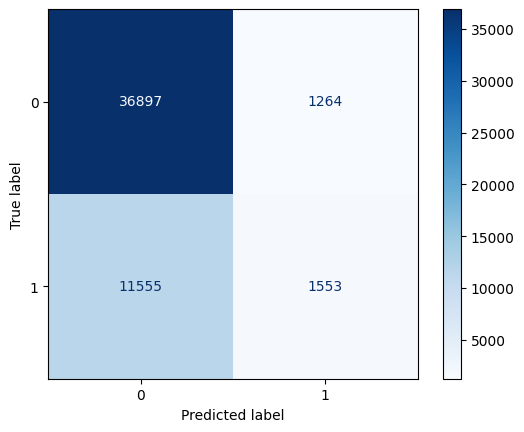

In [56]:
# 예측 결과 병합
y_test = pd.concat([IVF_y_test, DI_y_test])
y_pred = pd.concat([pd.Series(IVF_y_pred, index=IVF_y_test.index), pd.Series(DI_y_pred, index=DI_y_test.index)])
y_pred_proba = pd.concat([pd.Series(IVF_y_pred_proba, index=IVF_y_test.index), pd.Series(DI_y_pred_proba, index=DI_y_test.index)])

# 평가
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
cm = confusion_matrix(y_test, y_pred)

# 결과 출력
print()
print("--- Combined Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=IVF_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

데이콘 PUBLIC 0.7414156309

## 제출

In [65]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# 여러 LightGBM 모델 학습 및 앙상블 구성
def train_and_ensemble(X, y, num_models=5, model_params=None):
    models = []
    for i in range(num_models):
        # 모델 초기화
        model = lgb.LGBMClassifier(
            **model_params,
            random_state=42 + i  # 각 모델에 다른 시드 값 사용
        )
        
        # 모델 학습
        model.fit(X, y)
        models.append(model)
    
    return models

# 앙상블 예측 함수
def ensemble_predict(models, X):
    preds = np.zeros((X.shape[0], len(models)))
    for i, model in enumerate(models):
        preds[:, i] = model.predict_proba(X)[:, 1]
    return np.mean(preds, axis=1)

# IVF 데이터에 대해 여러 LightGBM 모델 학습 및 앙상블 구성
IVF_model_params = {
    'n_estimators': 4471,
    'num_leaves': 13,
    'max_depth': 279,
    'learning_rate': 0.007075124517450591,
    'min_child_samples': 26,
    'subsample': 0.29772991936701476,
    'colsample_bytree': 0.8913054521763838,
    'reg_alpha': 0.0004860363321690653,
    'reg_lambda': 311.08056657247363,
    'min_split_gain': 0.18214905183450955,
    'boosting_type': 'gbdt',
    'verbose': -1
}
IVF_models = train_and_ensemble(IVF_X, IVF_y, num_models=5, model_params=IVF_model_params)

# 앙상블 예측
IVF_pred_proba = ensemble_predict(IVF_models, IVF_test.drop(['ID', 'probability'], axis=1, errors='ignore'))

# DI 데이터에 대해 여러 LightGBM 모델 학습 및 앙상블 구성
DI_model_params = {
    'n_estimators': 1816,
    'num_leaves': 3926,
    'max_depth': 259,
    'learning_rate': 0.00238377640011148,
    'min_child_samples': 1,
    'subsample': 0.7610056627240331,
    'colsample_bytree': 0.6655579164853634,
    'reg_alpha': 0.00025227758337188327,
    'reg_lambda': 76.744107215122684,
    'min_split_gain': 0.007773520329665474,
    'boosting_type': 'gbdt',
    'verbose': -1
}
DI_models = train_and_ensemble(DI_X, DI_y, num_models=5, model_params=DI_model_params)

# 앙상블 예측
DI_pred_proba = ensemble_predict(DI_models, DI_test.drop(['ID', 'probability'], axis=1, errors='ignore'))

# 예측 결과 병합
IVF_test['probability'] = IVF_pred_proba
DI_test['probability'] = DI_pred_proba

# 최종 제출 파일 생성
submission = pd.concat([IVF_test[['ID', 'probability']], DI_test[['ID', 'probability']]], axis=0)
submission = submission.sort_values(by='ID')

# 제출 파일 저장
submission.to_csv('../submission/code54_lgbm_BG.csv', index=False, encoding='utf-8')

# 예측 결과 확인
print(submission.head())

           ID  probability
0  TEST_00000     0.001150
1  TEST_00001     0.001186
2  TEST_00002     0.148630
3  TEST_00003     0.106348
4  TEST_00004     0.503013


---

In [68]:
import pandas as pd

# 두 CSV 파일을 읽어옵니다.
# df1 = pd.read_csv('../submission/code26_voting_upgrad_submit_LgbmXgb.csv')
df1 = pd.read_csv('../submission/code26_submit.csv')
df2 = pd.read_csv('../submission/code54_lgbm_BG.csv')

# ID를 기준으로 병합하여 값이 다른 행을 찾습니다.
merged_df = pd.merge(df1, df2, on='ID', suffixes=('_df1', '_df2'))

# 'probability' 열의 값이 다른 행을 필터링합니다.
different_rows = merged_df[merged_df['probability_df1'] != merged_df['probability_df2']]

In [67]:
different_rows

,ID,probability_df1,probability_df2
0,TEST_00000,0.001148,0.001150
1,TEST_00001,0.001176,0.001186
2,TEST_00002,0.150113,0.148630
3,TEST_00003,0.107224,0.106348
4,TEST_00004,0.500233,0.503013
...,...,...,...
90062,TEST_90062,0.001407,0.001416
90063,TEST_90063,0.306604,0.307971
90064,TEST_90064,0.524196,0.525682
90065,TEST_90065,0.217687,0.218108


---

.